In [ ]:
!cd .. && maturin build --release

In [ ]:
%pip install /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl --force-reinstall

In [4]:
import sys
sys.path.append('..')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
from natsort import natsorted
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import groupby
from collections import namedtuple
import math
import time
from PropLang import PropLang
from MathLang import MathLang
import rejoice
from rejoice import EGraph
from rejoice.lib import Language
from rejoice.pretrain_dataset_gen import EGraphSolver
from os import listdir
from natsort import natsort_keygen

/home/ubuntu/anaconda3/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-20 22:13:55.004981: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# !sudo apt install --yes cm-super dvipng texlive-fonts-recommended texlive-latex-extra texlive-latex-recommended

In [55]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['font.size'] = 18

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Limitations of Equality Saturation

In [ ]:
def run_egg(lang: Language, expr, node_limit=10_000, iter_limit=7):
    print(f"running egg for expr", expr)
    first_stamp = int(round(time.time() * 1000))
    egraph = EGraph()
    egraph.add(expr)
    stop_reason, num_applications, num_enodes, num_eclasses = egraph.run(lang.rewrite_rules(), iter_limit=iter_limit, node_limit=node_limit)
    print(stop_reason, "num_applications", num_applications, "num_enodes", num_enodes, "num_eclasses", num_eclasses)
    best_cost, best_expr = egraph.extract(expr)
    second_stamp = int(round(time.time() * 1000))
    # Calculate the time taken in milliseconds
    time_taken = second_stamp - first_stamp
    # egraph.graphviz("egg_best.png")
    print(f"egg best cost:", best_cost, "in",
            f"{time_taken}ms", "best expr: ", best_expr)
    return best_cost, best_expr, num_applications, num_enodes

In [ ]:
lang = MathLang()
ops = lang.all_operators_obj()
Add, Integral, Mul, Pow, Diff, Ln, Div, Cos, Sub, Sqrt = ops.add, ops.integral, ops.mul, ops.pow, ops.diff, ops.ln, ops.div, ops.cos, ops.sub, ops.sqrt
expr = ops.sub(ops.add(16, 2), 0)
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count_math.pdf", bbox_inches='tight')


In [ ]:
lang = PropLang()
ops = lang.all_operators_dict()
AND, NOT, OR, IM = ops["and"], ops["not"], ops["or"], ops["implies"]
x, y, z = "x", "y", "z"
expr = OR(AND(x, y), IM(x, z))
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count.pdf", bbox_inches='tight')


In [ ]:
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"
df2["enodes_added"] = df2["num_enodes"].diff()
df2 = df2.groupby("action_name").agg('sum').reset_index()
df2 = df2[["action_name", "num_applications", "enodes_added"]]
df2 = df2.melt("action_name")
plt.rcParams['font.size'] = 18
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="action_name", y="value", hue="variable", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.set_xlabel("Rewrite Rule")
ax.set_ylabel("Count")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0)
leg = ax.axes.get_legend()
leg.set_frame_on(False)

new_labels = ['Applications', 'Nodes added']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig("sync/egg_limits_rules.pdf", bbox_inches='tight')

# Single-Task Performance

## Easy task

In [29]:
def smooth(scalars: list[float], weight=0.9) -> list[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [ ]:
# Load log data
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_training = df[df['dir_name'] == 'egraph-v0__ppo__1__1655144794']
df_prop["Lang"] = "PROP"
# TODO: change this
df_math = df[df['dir_name'] == 'egraph-v0__ppo__1__1655273840']
df_math["Lang"] = "MATH"

plang = PropLang()
psat_expr = plang.get_single_task_exprs().saturatable
psolver = EGraphSolver(lang=plang, expr=psat_expr)
p_best_cost, p_best_expr, p_num_applications, p_num_enodes = run_egg(plang, psat_expr)

mlang = MathLang()
msat_expr = mlang.get_single_task_exprs().saturatable
msolver = EGraphSolver(lang=mlang, expr=msat_expr)
m_best_cost, m_best_expr, m_num_applications, m_num_enodes = run_egg(mlang, msat_expr)

def smooth_tensorboard_plots(df):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist())
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist())
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist())
    df2 = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length, "Lang": df.iloc[0]["Lang"]})
    return df2

def plot_single_task_easy_grid(df_prop, df_math):
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length', 'charts/acc_rewrites']

    df_prop = df_prop.loc[df_prop['tag'].isin(chart_list)]
    df_math = df_math.loc[df_math['tag'].isin(chart_list)]

    df_prop = df_prop[df_prop["step"] < 130_000]
    df_math = df_math[df_math["step"] < 130_000]
    # find steps where episodic_cost is minimum
    # then get min of acc_rw of those rows
    # df_prop.groupby("step")
    df_prop_minlen = 7

    df_prop = smooth_tensorboard_plots(df_prop)
    df_math = smooth_tensorboard_plots(df_math)

    df_math_minlen = 4
    
    df_all = pd.concat([df_prop, df_math])

    df = pd.melt(df_all, id_vars=["Lang"], ignore_index=False)
    # plt.figure(figsize=(5, 10))
    g = sns.relplot(x=df.index, y="value", row="variable", col="Lang", kind="line", data=df, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)

    # g.set(xlabel="Episode")
    g.fig.subplots_adjust(wspace=.2, hspace=.1)
    ylabels = ["Episodic Return", "",
              "Episodic Cost", "",
              "Episodic Length", ""]

    for ind, ax in enumerate(g.axes.flatten()):
        if ind == 0:
            ax.set_title("PROP", pad=20, fontweight="bold")
        elif ind == 1:
            ax.set_title("MATH", pad=20, fontweight="bold")
        else:
            ax.set_title("")

        if ind not in [4, 5]:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind in [4, 5]:
            ax.set_xlabel("Episode")

    # create separate barplot
    # Lang, num_applications_egg, num_applications_omelette
    data = [["PROP", p_num_applications, df_prop_minlen],
            ["MATH", m_num_applications, df_math_minlen]]
    df = pd.DataFrame(data, columns=["Lang", "Egg", "Omelette"])   
    df = df.melt(["Lang"])
    return g, df

g, bpdf = plot_single_task_easy_grid(df_prop, df_math)
g.fig.savefig("sync/single_task_easy.pdf", bbox_inches='tight')

In [ ]:
bp = sns.catplot(x="variable", y="value",
            col="Lang",
            kind="bar", data=bpdf, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():2}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps.pdf")


## Hard Task

In [79]:
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'egraph-v0__PropLang_8__1__1655607444']

def smooth_tensorboard_plots(df, weight=0.9):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist(), weight=weight)
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist(), weight=weight)
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist(), weight=weight)
    df = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length})
    return df

/tmp/ipykernel_22742/1442740324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data['total_apps'] = step_data.groupby('solver')['num_applications'].cumsum()


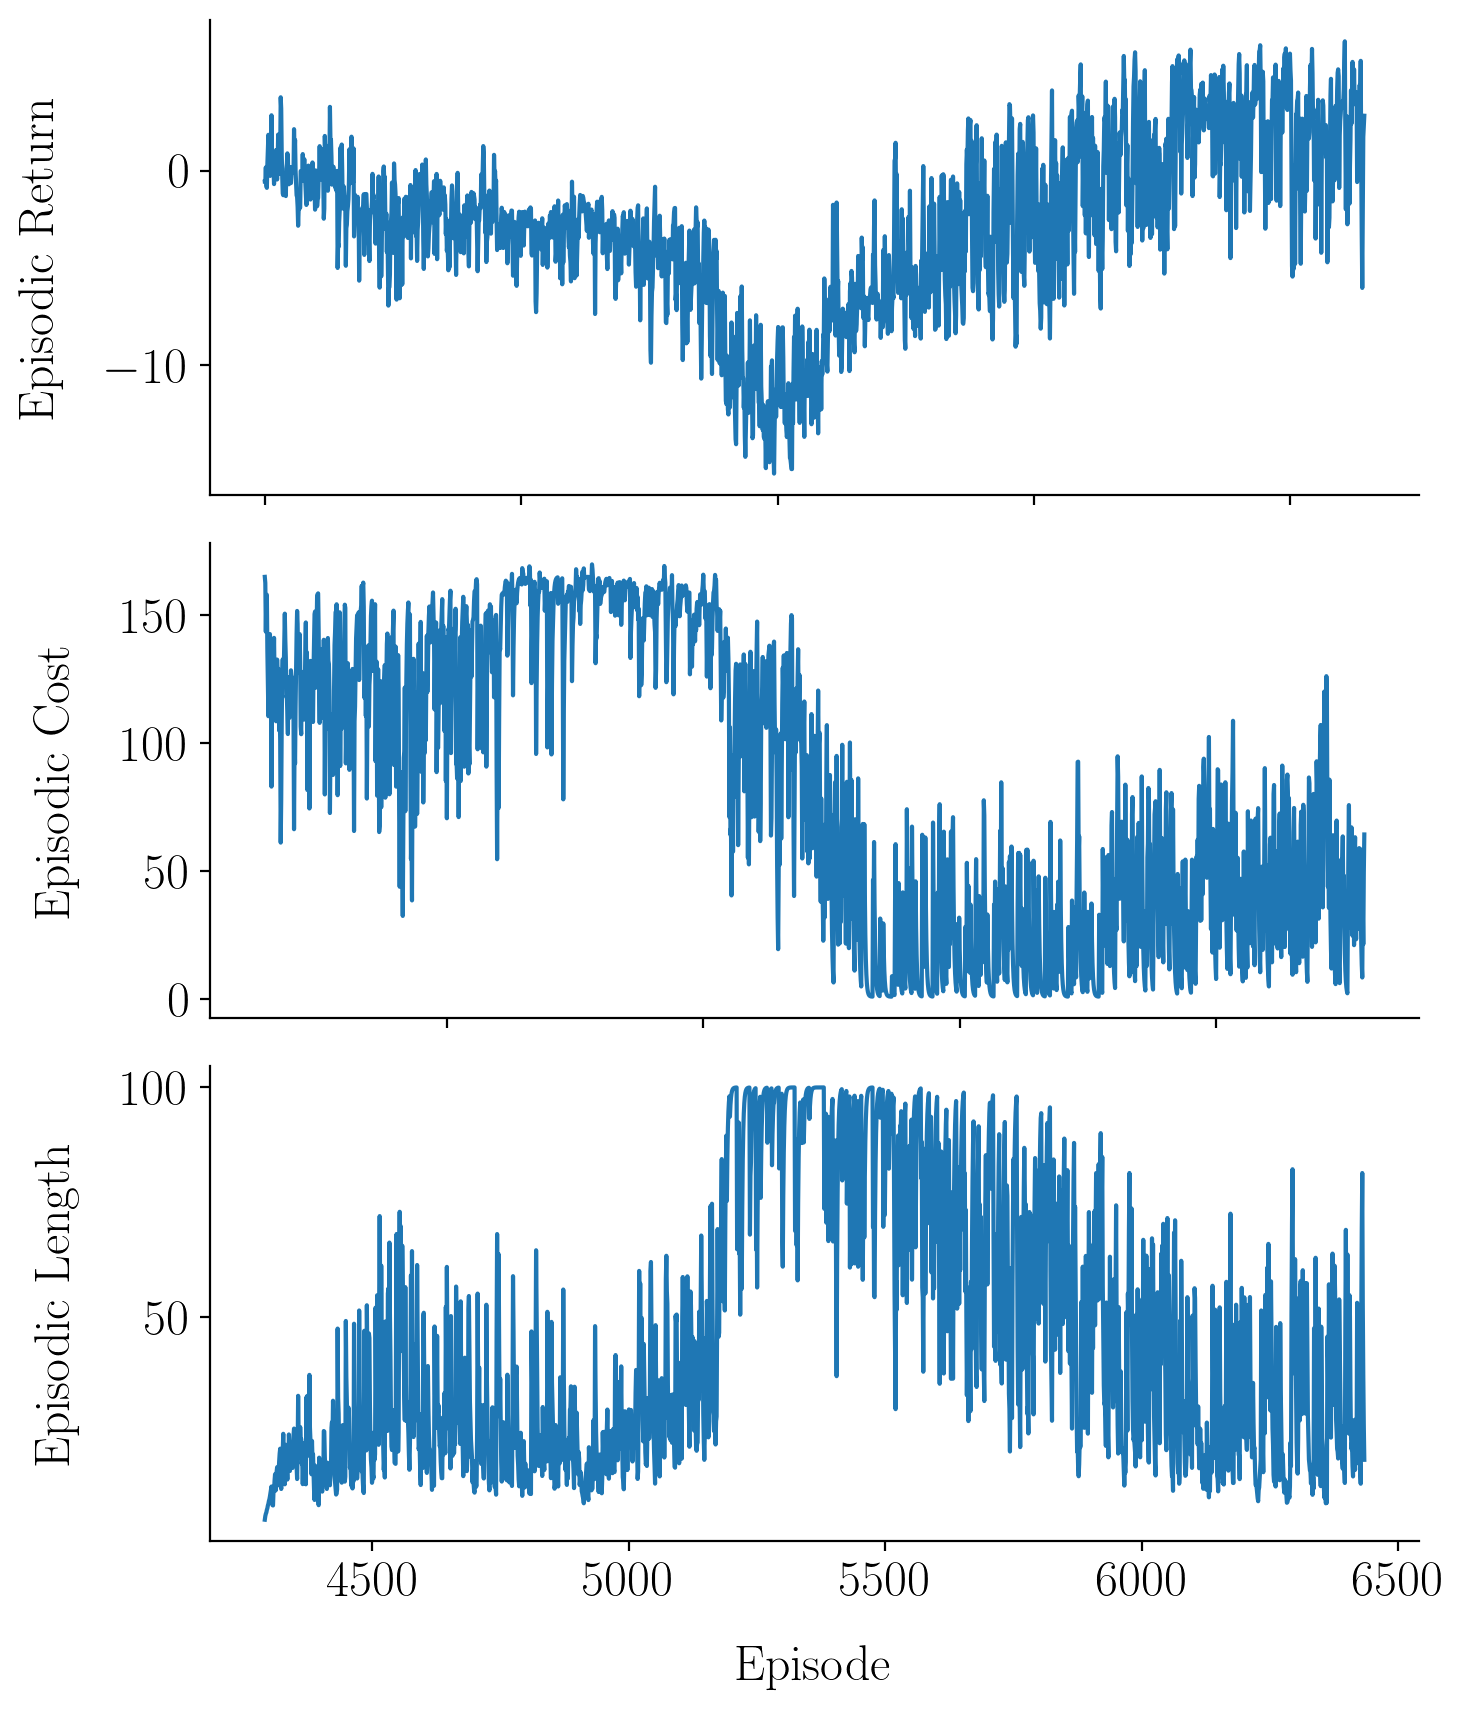

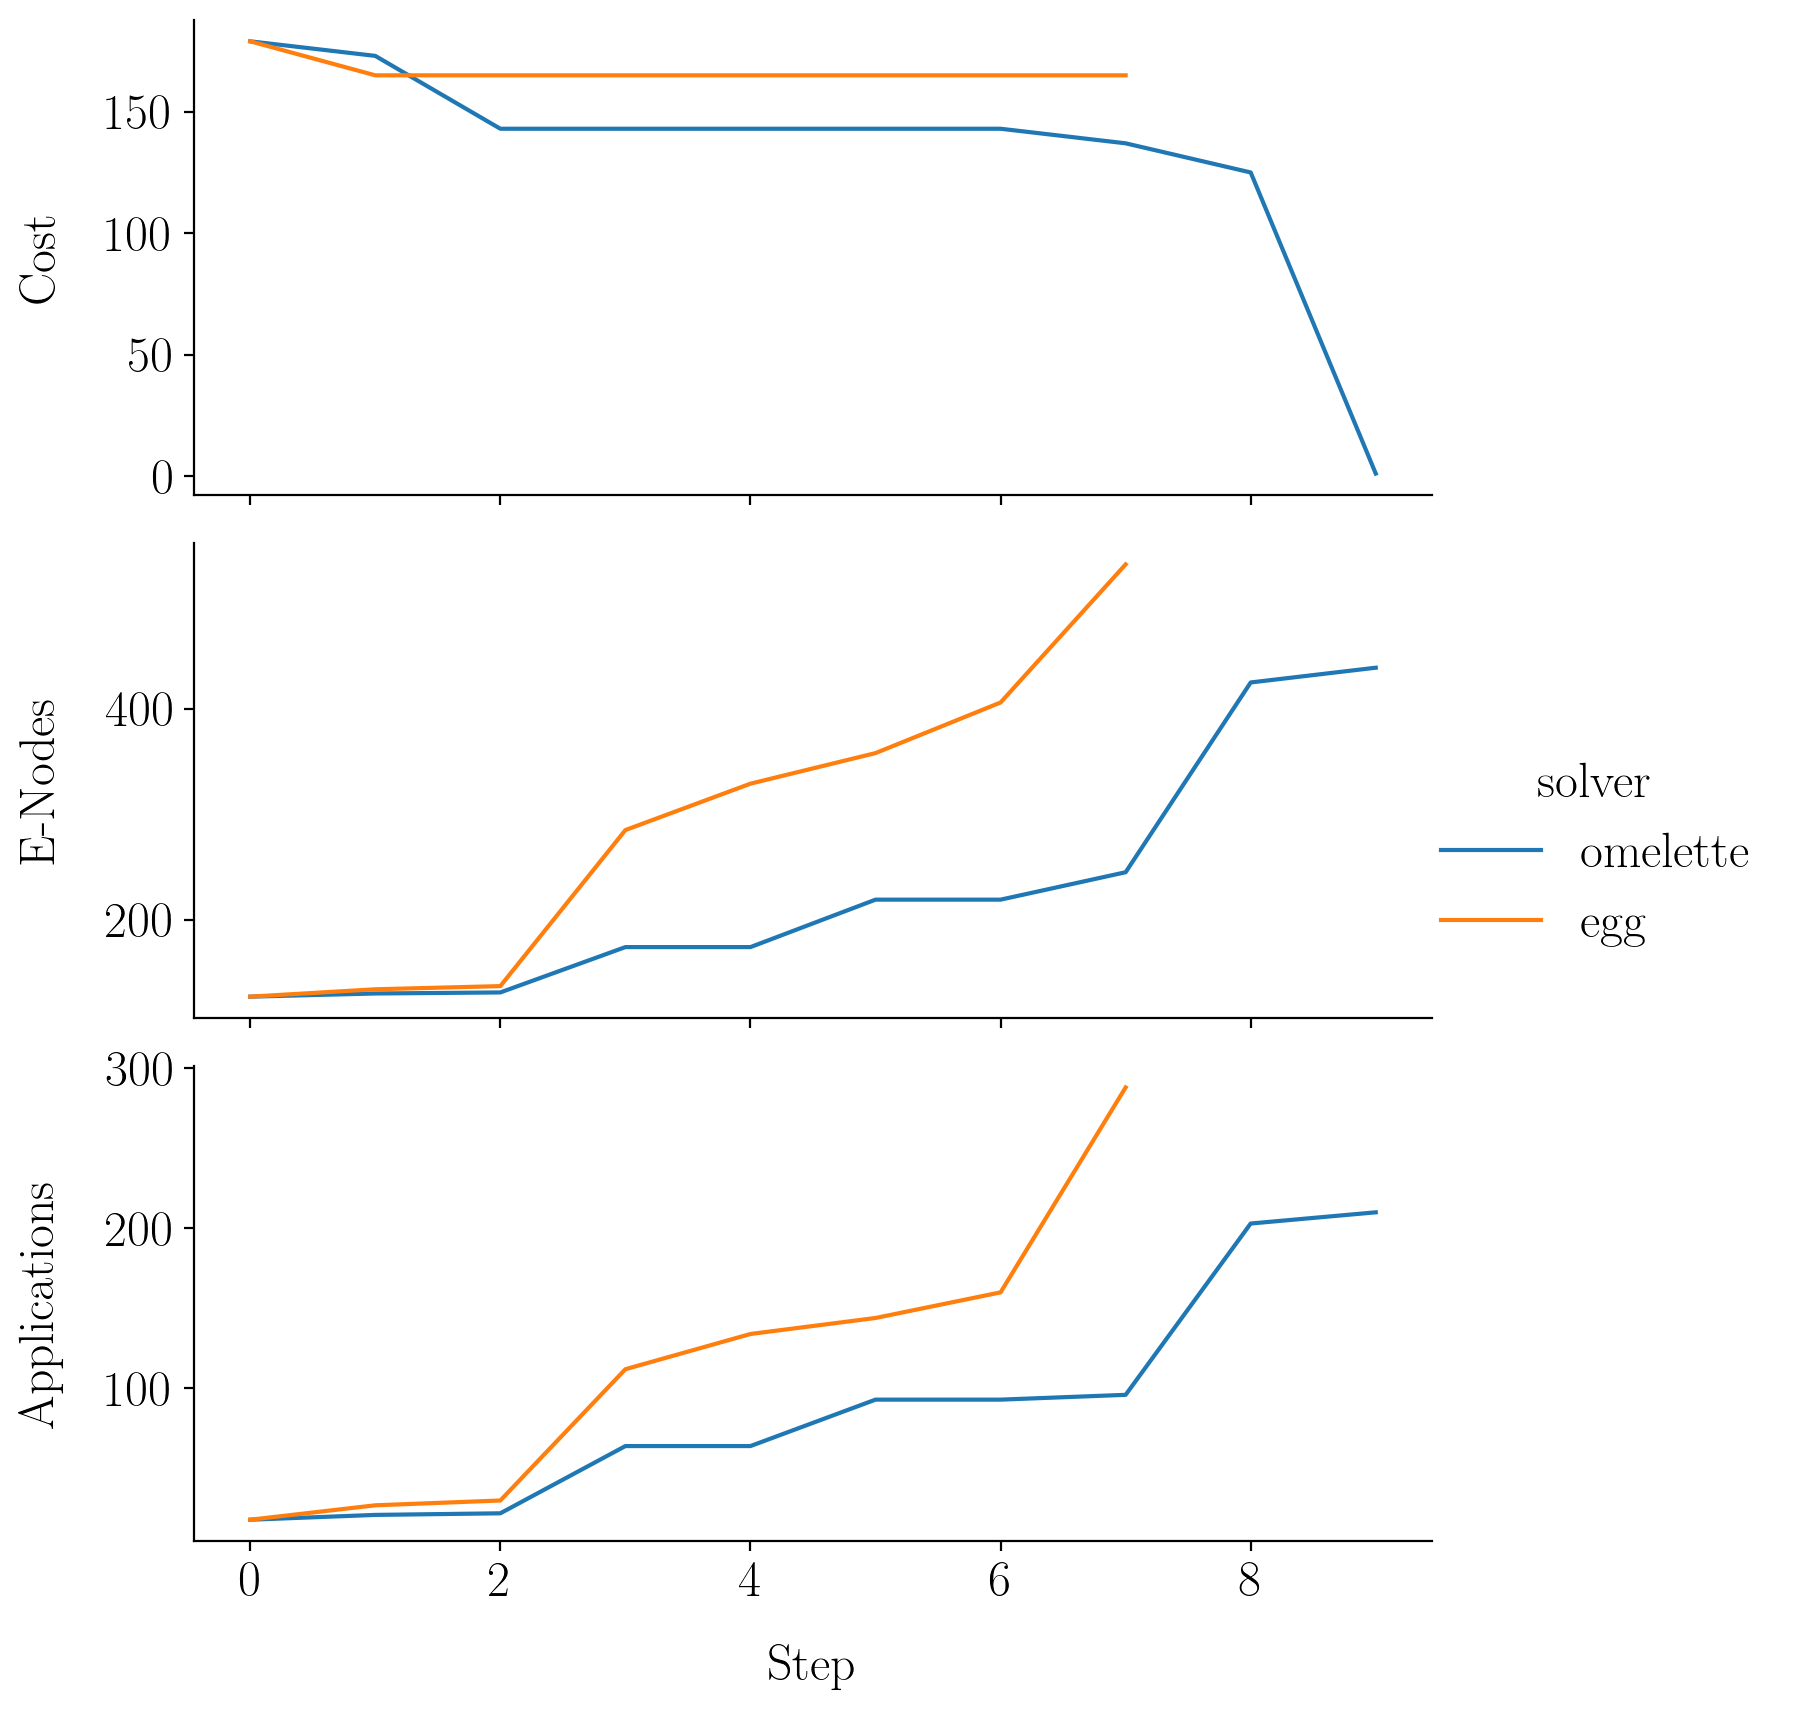

In [99]:

def plot_single_task_hard_grid(df_training, step_data):
    # get training curve data from tensorboard
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length']
    df_training = df_training.loc[df_training['tag'].isin(chart_list)]
    df_training = smooth_tensorboard_plots(df_training, weight=0.6)
    df_training = df_training.melt()

    # get step data:
    # cost over steps (compared b/w this and egg)
    # accumulated rewrites over steps
    # node count over steps

    step_data = step_data[["solver", "step_ind", "cost", "num_enodes", "num_applications"]]
    step_data['total_apps'] = step_data.groupby('solver')['num_applications'].cumsum()
    step_data = step_data.drop(columns=["num_applications"])
    step_data = step_data.melt(["solver", "step_ind"])

    # fig, axes = plt.subplots(1, 2)

    g1 = sns.relplot(x=df_training.index, y="value", row="variable", kind="line", data=df_training, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)
    g1.fig.subplots_adjust(hspace=.1)
    ylabels = ["Episodic Return",
              "Episodic Cost",
              "Episodic Length"]

    for ind, ax in enumerate(g1.axes.flatten()):
        ax.set_title("")

        if ind < 2:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind == 2:
            ax.set_xlabel("Episode")


    g2 = sns.relplot(x="step_ind", y="value", row="variable", hue="solver", kind="line", data=step_data, facet_kws={'sharey': False, 'sharex': True}, height=3, aspect=2.5/1)
    g2.fig.subplots_adjust(hspace=.1)
    ylabels = ["Cost",
              "E-Nodes",
              "Applications"]

    for ind, ax in enumerate(g2.axes.flatten()):
        ax.set_title("")

        # if ind < 2:
        #     ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        
        ax.set_xlabel("")
        if ind == 2:
            ax.set_xlabel("Step")

    return g1, g2

all_data = load_data()
step_data = all_data[all_data["expr_ind"] == '8'].set_index(["step_ind"]).reset_index()

g1, g2 = plot_single_task_hard_grid(df_prop, step_data)
g1.fig.savefig("sync/single_task_hard_training.pdf", bbox_inches='tight')
g2.fig.savefig("sync/single_task_hard_steps.pdf", bbox_inches='tight')

In [ ]:
all_data = load_data()
step_data = all_data[all_data["expr_ind"] == '1'].set_index(["step_ind"]).reset_index()

g1, g2 = plot_single_task_hard_grid(df_prop, step_data)
g1.fig.savefig("sync/single_task_hard_training.pdf", bbox_inches='tight')
g2.fig.savefig("sync/single_task_hard_steps.pdf", bbox_inches='tight')

# Pretraining Graphs

### PROP

##### Dataset analysis

In [3]:
def load_dataset(dataset_dir: str):
  files = os.listdir(dataset_dir)
  files.sort()
  keyf = lambda f: f.split("_")[0]

  files_grouped_by_expr = [list(expr_files) for gr, expr_files in groupby(files, key=keyf)]

  Row = namedtuple('Row', ['max_cost', 'min_cost', 'om_actions', 'egg_actions', 'action_mult', 'om_enodes', 'egg_enodes', 'enodes_mult', 'om_eclasses', 'egg_eclasses', 'eclasses_mult'])

  rows = []

  for group in files_grouped_by_expr:
    min_actions = len(group)
    # pick the last data object (the one from termination)
    d = torch.load(dataset_dir + "/" + group[-1])
    num_eclasses = int(torch.sum(d["x"][:, 0]).item())
    num_enodes = int(len(d["x"]) - num_eclasses)

    node_mult = (d.egg_enodes / num_enodes)
    class_mult = (d.egg_eclasses / num_eclasses)
    action_mult = (d.egg_rewrites / min_actions)

    rows.append(Row(max_cost=d.max_cost, min_cost=d.min_cost, om_actions=min_actions, egg_actions=d.egg_rewrites, action_mult=action_mult,
        om_enodes=num_enodes, egg_enodes=d.egg_enodes, enodes_mult=node_mult,
        om_eclasses=num_eclasses, egg_eclasses=d.egg_eclasses, eclasses_mult=class_mult))
    
  return pd.DataFrame(rows)

In [ ]:
df = load_dataset("../PropLang")
print(df)
df = df[["action_mult", "enodes_mult", "eclasses_mult"]]
df_melted = pd.melt(df)
plt.figure(figsize = (15,8))
g = sns.boxplot(x='variable', y='value', data=df_melted)
g.set(ylabel="Multiplier", xlabel="Attribute", yscale="log")
plt.savefig("prop_data.pdf")

In [ ]:
df = load_dataset("../PropLang")
data = pd.DataFrame({"Egg": [df["egg_actions"].mean()], "Omelette": [df["om_actions"].mean()]})
data = pd.melt(data)
print(data)

In [ ]:

bp = sns.catplot(x="variable", y="value",
            kind="bar", data=data, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps_dataset.pdf")

##### Training/Test Accuracy Plots

In [ ]:
# Load log data
log_dir = "../lightning_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'prop']
df_math = df[df['dir_name'] == 'math']


In [ ]:
def plot_acc(df, title):
  g = sns.lineplot(data=df, x='step', y='value')
  g.set(title=title, ylabel="Accuracy", xlabel="Step")
  return g

In [ ]:
def plot_acc_grid(df1, df2):
  df1 = df1.loc[df1['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df2 = df2.loc[df2['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df_all = pd.concat([df1, df2])

  g = sns.relplot(x="step", y="value", col="tag", row="dir_name", kind="line", data=df_all);
  g.set(ylabel="Accuracy", xlabel="Step")
  return g

g = plot_acc_grid(df_prop, df_math)
plt.savefig("sup_acc.pdf")

In [ ]:
train_acc_df = df[df['tag'] =='acc/train_acc']
plot_acc(train_acc_df, "Training Accuracy")

In [ ]:
al_acc_df = df[df['tag'] =='acc/val_acc']


In [ ]:
# Breakdown by operator type count


# Single-Task Performance

In [423]:
def load_data(lang="PropLang", include_rand=False):
    dfs = []
    for file in listdir("../dataset_metrics"):
        fsplit = file.split("_")
        flang = fsplit[0]
        solver = fsplit[2]
        if not include_rand:
            if solver == 'random':
                continue
        
        if solver == "om":
            continue  # we only want fixed versions now

        if flang != lang:
            continue
    
        expr_ind = fsplit[1]
        df = pd.read_feather(f"../dataset_metrics/{file}")
        df["expr_ind"] = expr_ind

        if fsplit[2] == "om" or fsplit[2] == "omfixed":
            # om doesn't end when it's done, manually slice
            min_ind = df["cost"].idxmin()
            df = df.iloc[:min_ind+1]
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.sort_values(["expr_ind", "step_ind"])
    return df

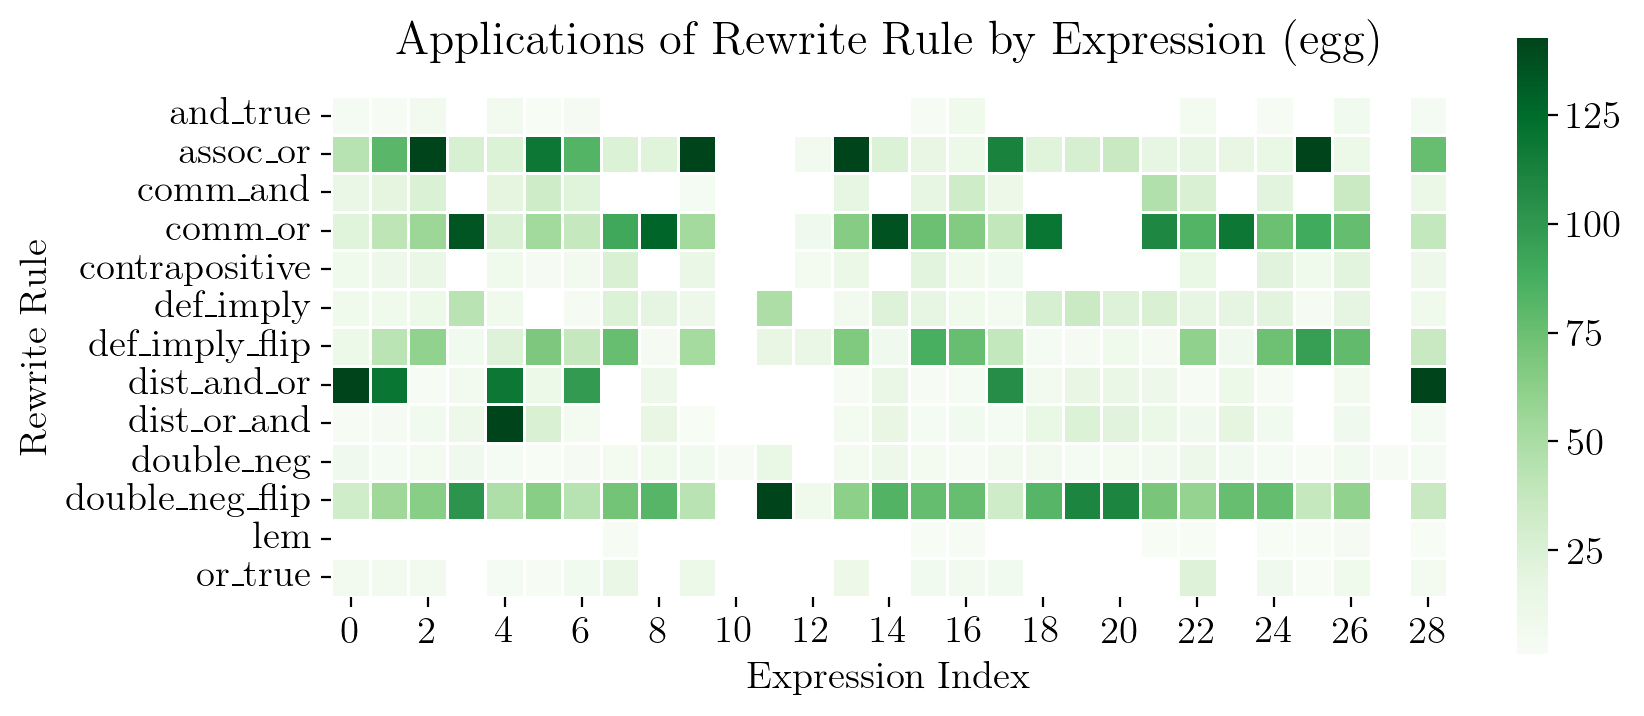

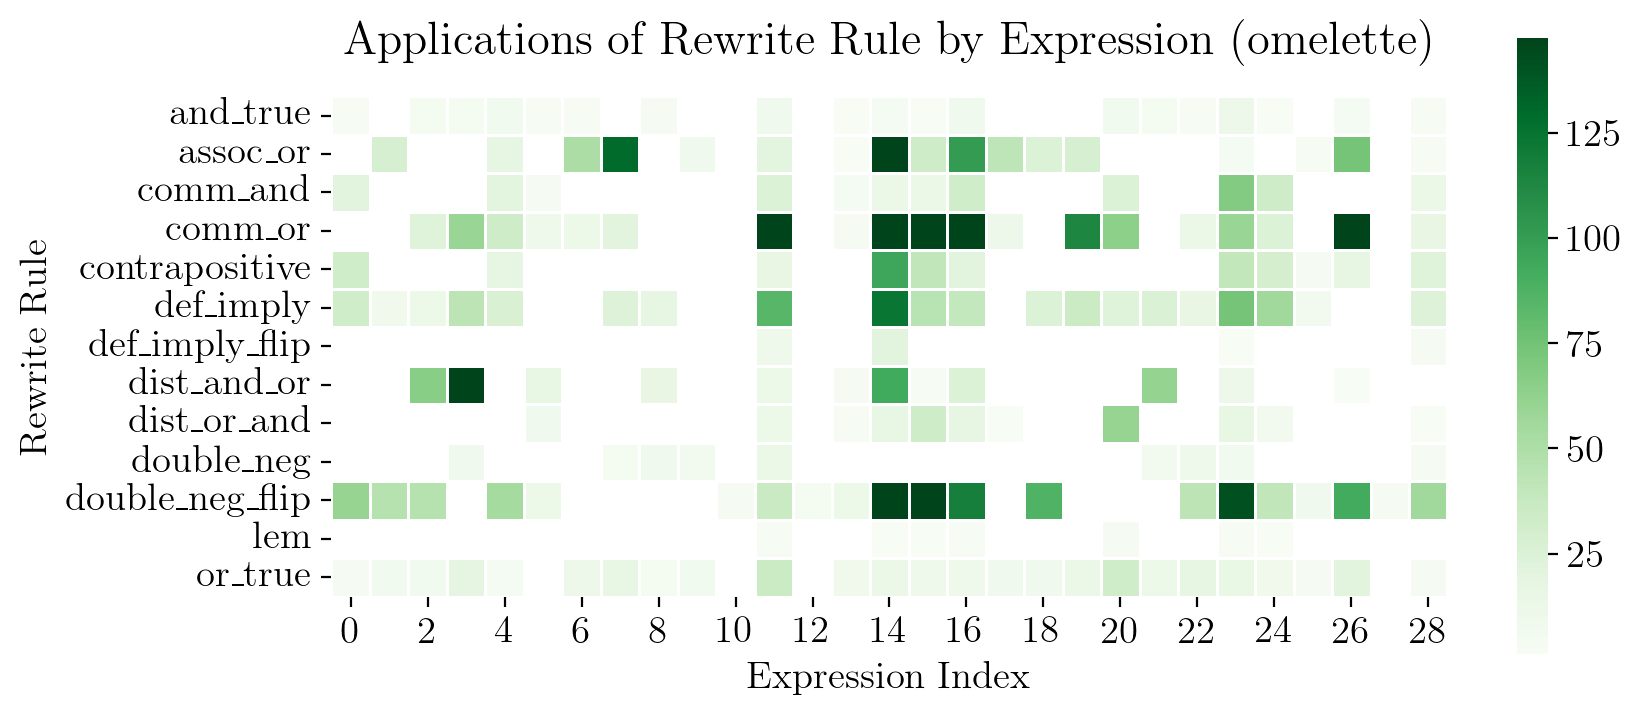

In [422]:
# Rule application heatmap
from matplotlib.colors import LogNorm, Normalize

df = load_data()
egg = df[df["solver"] == "egg"]
om = df[df["solver"] == "omelette"]

hm_egg = egg.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_egg = hm_egg.reindex(natsorted(hm_egg.columns), axis=1)

hm_om = om.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_om = hm_om.reindex(natsorted(hm_om.columns), axis=1)

def rule_app_hm(data, solver):
    plt.figure(figsize = (9,4))
    plt.rcParams['font.size'] = 14
    green = sns.color_palette("Greens", as_cmap=True).copy()
    green.set_under('white')
    g = sns.heatmap(data, cmap=green, robust=True, square=True, linewidths=.5, vmin=1)
    g.set_title(f"Applications of Rewrite Rule by Expression ({solver})", pad=15, fontweight="bold")
    g.set(xlabel="Expression Index", ylabel="Rewrite Rule")
    g.get_figure().savefig(f"sync/rule_app_hm_{solver}.pdf", bbox_inches='tight')

rule_app_hm(hm_egg, "egg")
rule_app_hm(hm_om, "omelette")

In [457]:
def init_size_and_cost(lang, expr):
    lang = PropLang() if lang == 'PropLang' else MathLang()
    expr = lang.eval_expr(expr)
    egraph = EGraph()
    egraph.add(expr)
    best_cost, _ = egraph.extract(expr)
    return egraph.total_size()

def expr_summary(lang="PropLang", include_rand=False):
    """Collapse each expression to a row summarizing it."""
    df = load_data(lang, include_rand)
    
    grouped = df.groupby(['expr_ind', 'solver']).agg({
        'step_ind': 'last',
        'stop_reason': 'last',
        'cost': 'last',
        'num_enodes': 'last',
        'num_eclasses': 'last',
        'training_time': 'last',
        'num_applications': 'sum',
        'init_expr': ['first', 'nunique'],
    })


    grouped['init_size'] = grouped['init_expr', 'first'].apply(lambda x: init_size_and_cost(lang, x))
    grouped['n_rebase'] = grouped['init_expr', 'nunique'] - 1
    grouped = grouped.drop(columns=["init_expr"])
    grouped.columns = grouped.columns.get_level_values(0)


    grouped['training_time'] = grouped['training_time'] / 60_000 # convert to min
    grouped['step_ind'] = grouped['step_ind'] + 1 # convert index to step count

    
    grouped = grouped.rename(columns={'step_ind': 'num_actions'}).reset_index()
    grouped = grouped.pivot(index = "expr_ind", columns = "solver")
    grouped = grouped.sort_values(
        by=["expr_ind"],
        key=natsort_keygen()
    )
    grouped.cost = grouped.cost.astype(int)

    # grouped = grouped.drop(columns=["training_time", "num_eclasses"])
    grouped = grouped.rename(columns={'num_actions': "Actions", "num_enodes": "E-Nodes", "cost": "Cost", "num_applications": "Applications", "stop_reason": "Stop Reason", "training_time": "Training Time", "num_eclasses": "E-Classes", "init_size": "Initial Size", "n_rebase": "Rebases"})
    grouped = grouped.sort_index(axis=1)

    grouped["Cost", '\% Imp'] = round((grouped.Cost.egg - grouped.Cost.omelette) / grouped.Cost.egg * 100)
    grouped["Actions", '\% Imp'] = round((grouped["Actions"].egg - grouped["Actions"].omelette) / grouped["Actions"].egg * 100)
    grouped["Applications", '\% Imp'] = round((grouped["Applications"].egg - grouped["Applications"].omelette) / grouped["Applications"].egg * 100)
    grouped["E-Nodes", '\% Imp'] = round((grouped["E-Nodes"].egg - grouped["E-Nodes"].omelette) / grouped["E-Nodes"].egg * 100)

    if include_rand:
        grouped["Cost", '\% Imp (Rand)'] = round((grouped.Cost.egg - grouped.Cost.random) / grouped.Cost.egg * 100)
        grouped["Actions", '\% Imp (Rand)'] = round((grouped["Actions"].egg - grouped["Actions"].random) / grouped["Actions"].egg * 100)
        grouped["Applications", '\% Imp (Rand)'] = round((grouped["Applications"].egg- grouped["Applications"].random) / grouped["Applications"].egg * 100)
        grouped["E-Nodes", '\% Imp (Rand)'] = round((grouped["E-Nodes"].egg - grouped["E-Nodes"].random) / grouped["E-Nodes"].egg * 100)

    grouped.index.names = ['Expr']
    return grouped

print(expr_summary())


       Actions          Applications          Cost          E-Classes  \
solver     egg omelette          egg omelette  egg omelette       egg   
Expr                                                                    
0           19       24          381      150    6        4       272   
1           19        5          392       91   36        1       256   
2           18       10          426      159   39       31       211   
3            8       16          338      359  182       58       234   
4           20       17          499      182   54       52       310   
5           31        7          382       52   12       12       205   
6           19        7          348       77   36       17       192   
7           17        6          334      196   21       19        96   
8            8        7          288       51  165        1       237   
9           18        3          437       21    3        3       249   
10          26        1            2        3    2 

In [7]:
def results_table():
    s = expr_summary().style.format(precision=0).to_latex(hrules=True, multicol_align="|c|", position_float="centering", position="ht", label="table:prop_single_res", caption="Results across the expressions in the PROP dataset. Omelette finds better solutions for 17 of the 29 tasks, performs the same for 5, and worse for 7.")

    with open("sync/cost_table.tex", "w") as text_file:
        text_file.write(s)

results_table()

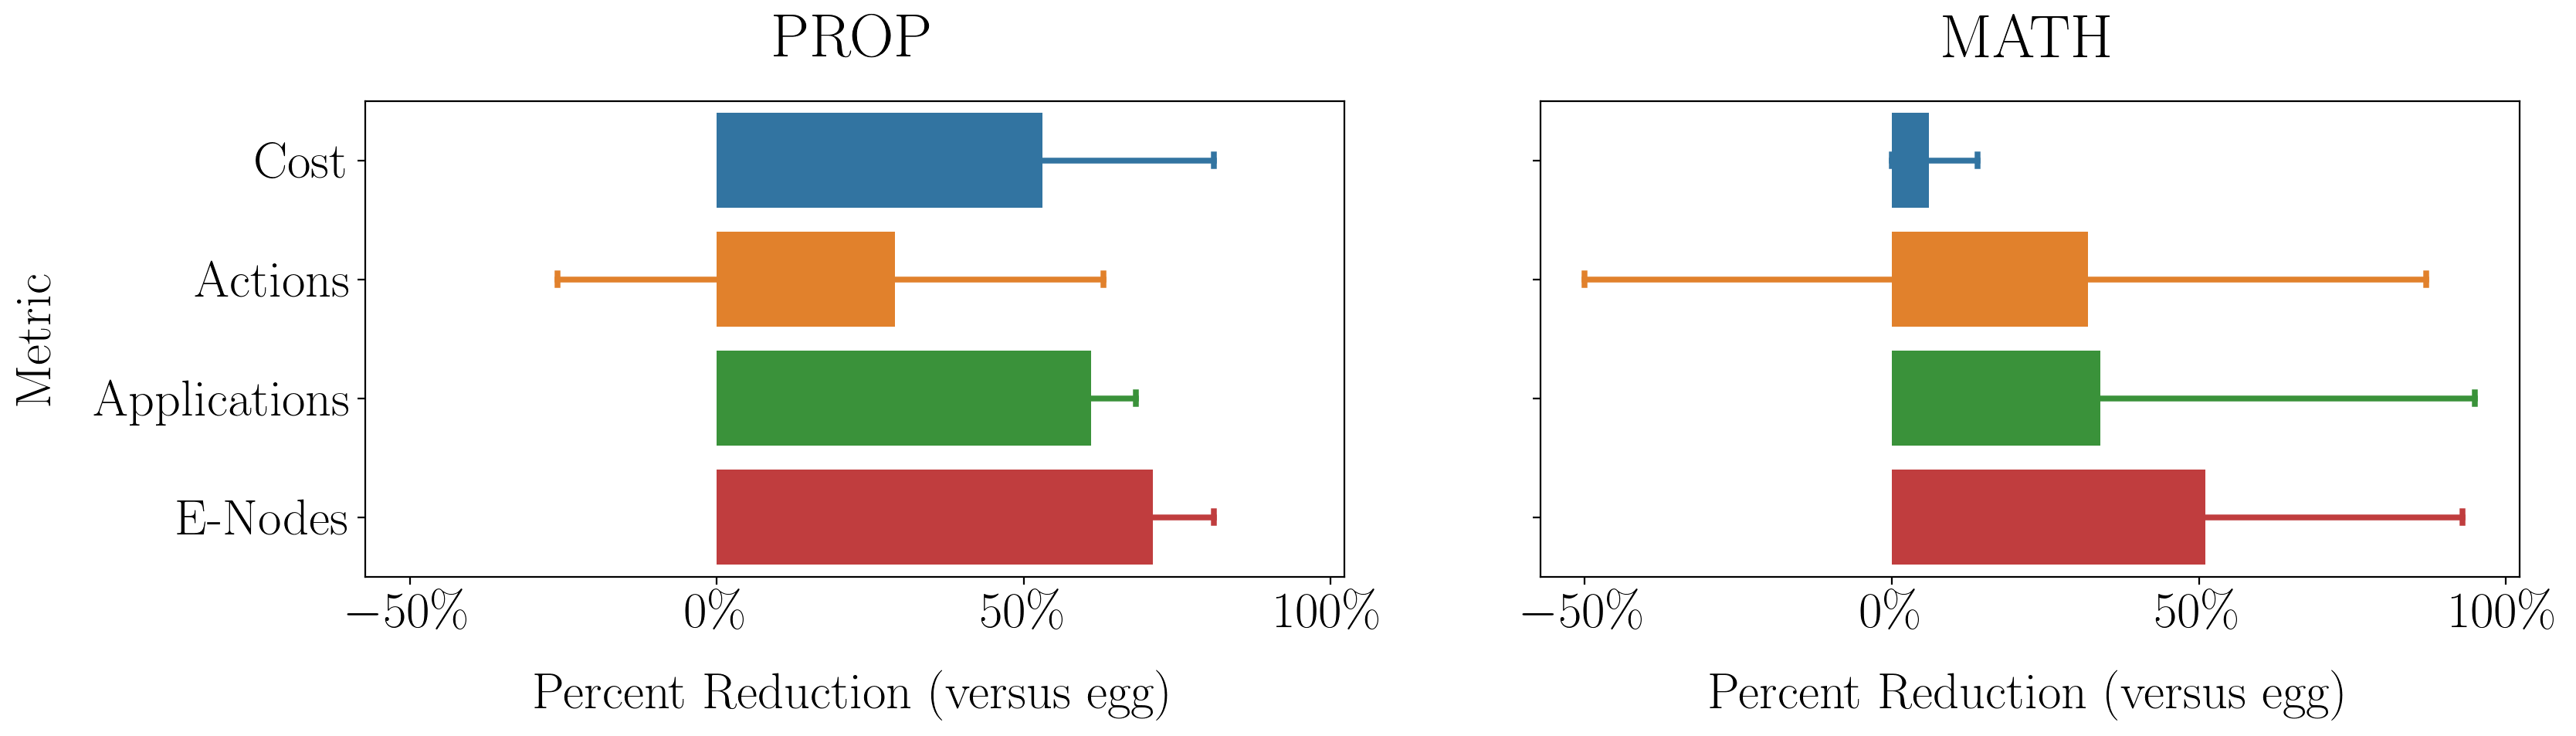

<Figure size 1800x800 with 0 Axes>

<Figure size 1800x800 with 0 Axes>

In [432]:
# Barplot for percent improvement across metrics

import matplotlib.ticker as mtick

def metric_summary(lang="PropLang", axes=None, ind=0):
    df = expr_summary(lang=lang)
    data = {"Cost": df["Cost", "\% Imp"],
            "Actions": df["Actions", "\% Imp"],
            "Applications": df["Applications", "\% Imp"],
            "E-Nodes": df["E-Nodes", "\% Imp"]}
    df = pd.DataFrame(data).reset_index()
    df = df.melt(["Expr"],  value_name="Percent Reduction (versus egg)", var_name="Metric")
    plt.figure(figsize = (9,4))
    ax = sns.barplot(data=df, y="Metric", x="Percent Reduction (versus egg)", estimator=np.median, capsize=.1, ax=axes)
    sns.despine(top=True, right=True)

    patches = ax.patches
    for i, line in enumerate(ax.get_lines()):
        newcolor = patches[i // 3].get_facecolor()
        line.set_color(newcolor)

    ax.xaxis.labelpad = 15
    if ind == 0:
        ax.yaxis.labelpad = 15
        ax.set_title('PROP', pad=20)
    else:
        ax.set(ylabel=None)
        ax.set_title('MATH', pad=20)
    plt.rcParams['font.size'] = 24
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    return ax

fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18, 4))

metric_summary("PropLang", axes=ax0, ind=0)
metric_summary("MathLang", axes=ax1, ind=1)

fig.savefig("sync/metrics_both.pdf", bbox_inches='tight')


# Dataset Analysis

<AxesSubplot:title={'center':'Expression Breakdown by Operator Count'}, xlabel='Expression', ylabel='Operator'>

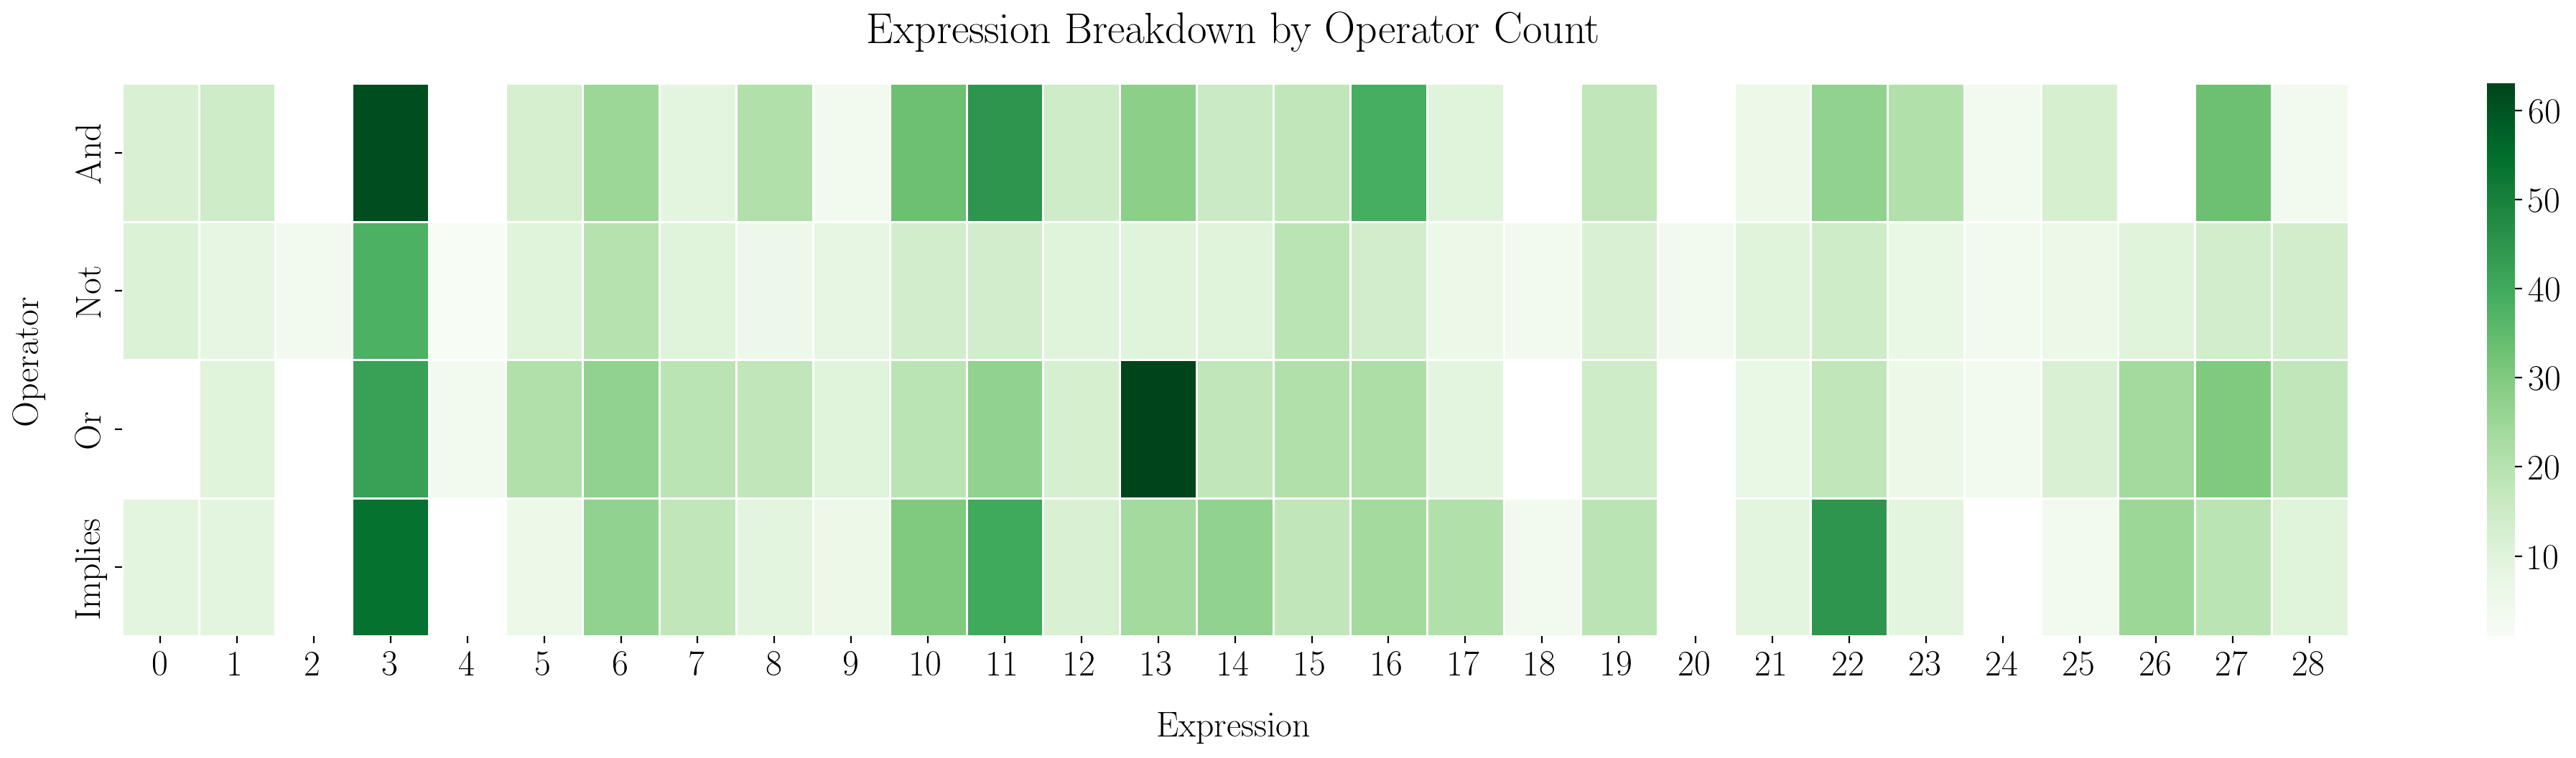

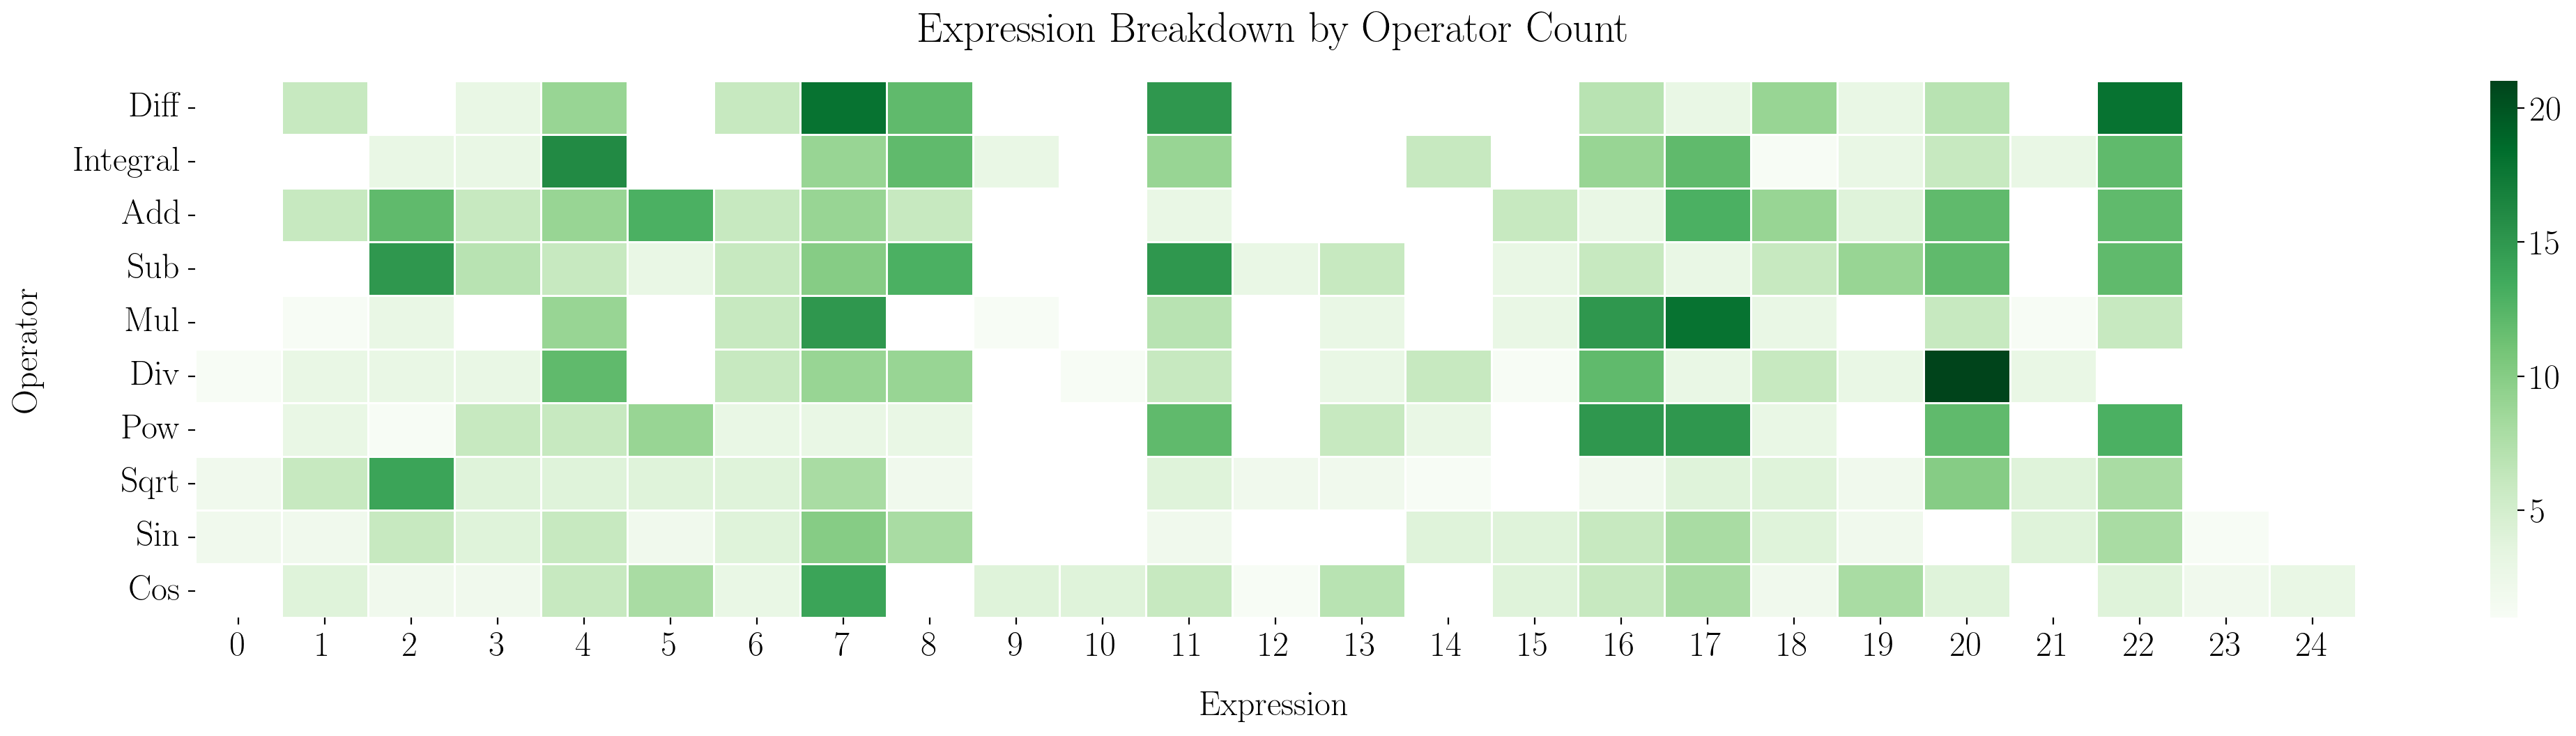

In [416]:
# Breakdown by node type

def dataset_breakdown(lang="PropLang", ax=None):
    df = load_data(lang=lang)
    operators = [s.capitalize() for s in (PropLang().operator_names() if lang == "PropLang" else MathLang().operator_names())]
    ind_to_expr = df.groupby(["expr_ind"])["init_expr"].first().reset_index(drop=True)
    e = ind_to_expr.apply(lambda x: x.replace("x=", "").replace("y=", ""))

    data_list = []
    for expr in e:
        op_counts = dict([(op, expr.count(op)) for op in operators])
        data_list.append(op_counts)


    df = pd.DataFrame(data_list).swapaxes("index", "columns")


    plt.figure(figsize = (25,5))

    green = sns.color_palette("Greens", as_cmap=True).copy()
    green.set_under('white')
    g = sns.heatmap(df, cmap=green, vmin=1, linewidths=.5, ax=ax)
    g.yaxis.labelpad = 15
    g.xaxis.labelpad = 15

    g.set_title(f"Expression Breakdown by Operator Count", pad=20, fontweight="bold")
    g.set(xlabel="Expression", ylabel="Operator")
    g.get_figure().savefig(f"sync/{lang}_data_heatmap.pdf", bbox_inches='tight')
    return g

dataset_breakdown("PropLang")
dataset_breakdown("MathLang")

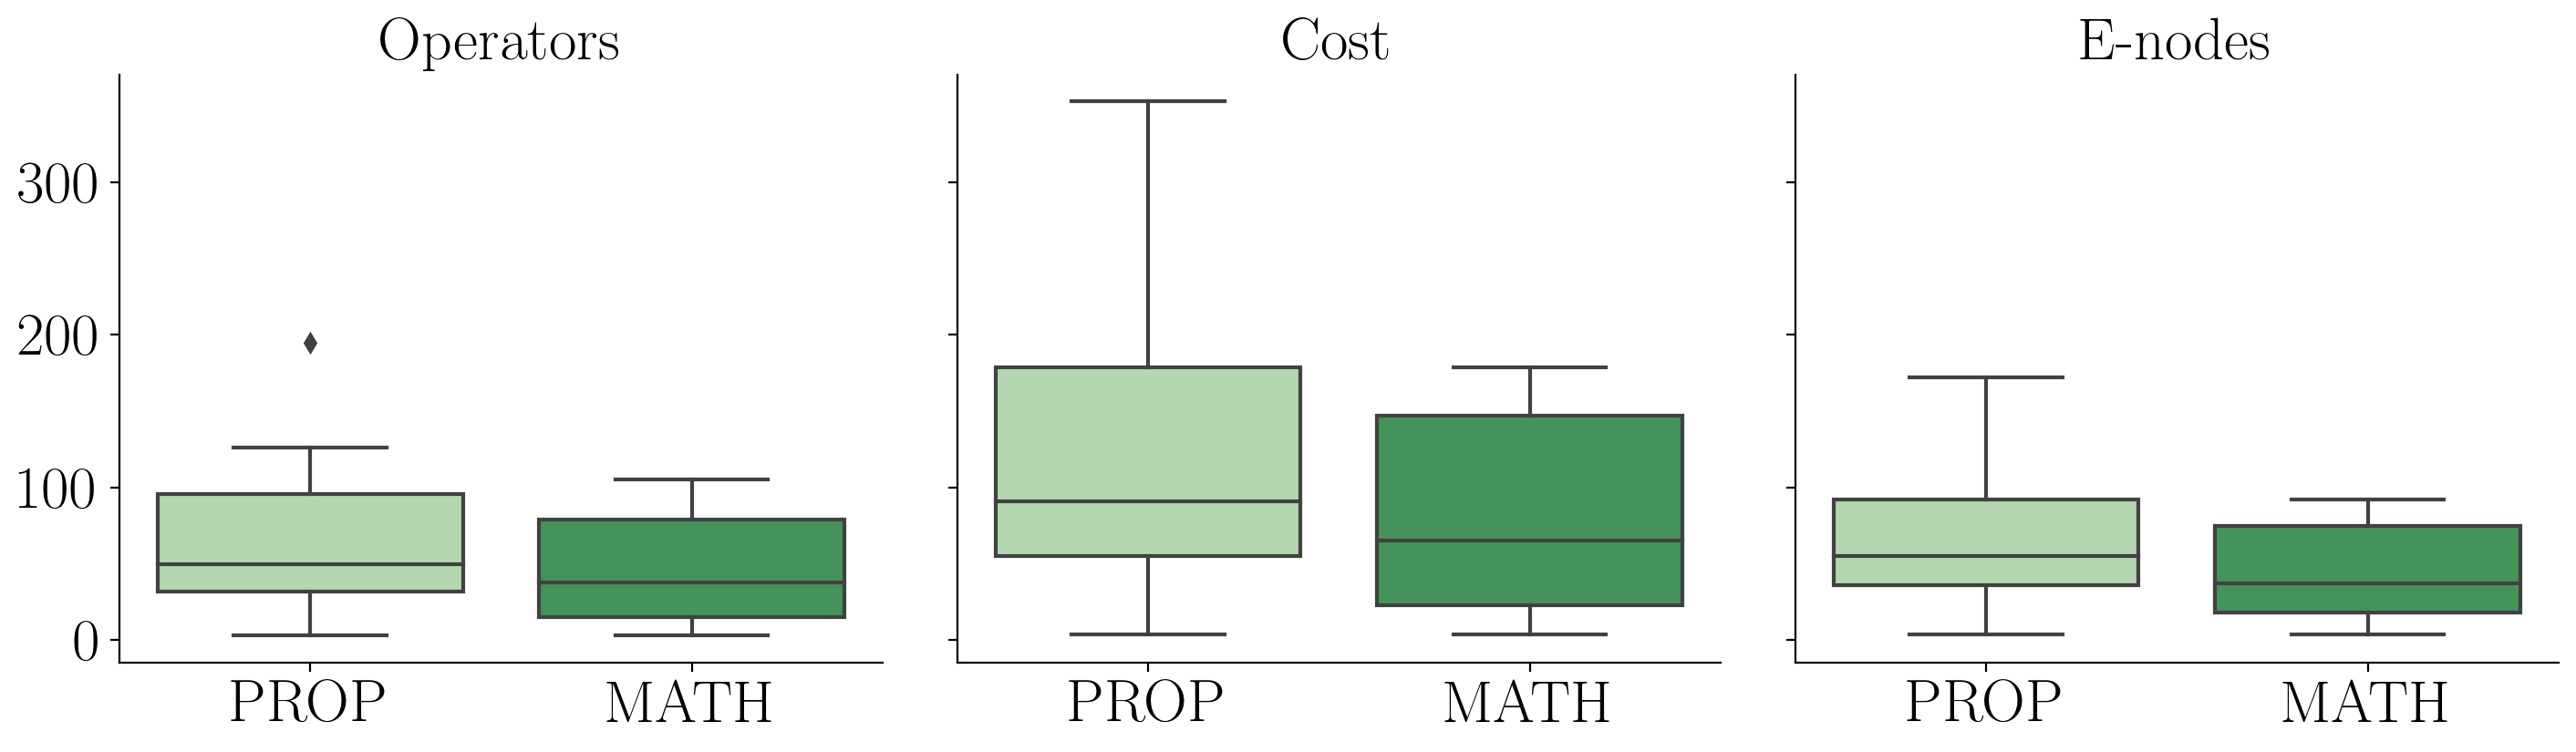

In [323]:
# Breakdown boxplots

# num_enodes in initial graph
# num_operators in initial graph
# cost of initial graph extraction
# hue'd by lang

def init_cost(lang, expr):
    expr = lang.eval_expr(expr)
    egraph = EGraph()
    egraph.add(expr)
    best_cost, _ = egraph.extract(expr)
    return best_cost

def num_enodes(lang, expr):
    expr = lang.eval_expr(expr)
    egraph = EGraph()
    egraph.add(expr)
    return egraph.total_size()

def dataset_breakdown(lang="PropLang"):
    df = load_data(lang=lang)
    lang = PropLang() if lang == 'PropLang' else MathLang()
    operators = [s.capitalize() for s in lang.operator_names()]
    df = df.groupby(["expr_ind"])["init_expr"].first().to_frame().reset_index()
    df["Operators"] = df.apply(lambda row: sum([row["init_expr"].count(op) for op in operators]), axis=1)
    df["Cost"] = df.apply(lambda row: init_cost(lang, row["init_expr"]), axis=1)
    df["E-nodes"] = df.apply(lambda row: num_enodes(lang, row["init_expr"]), axis=1)
    return df

pdf = dataset_breakdown(lang="PropLang")
pdf["lang"] = "PROP"
mdf = dataset_breakdown(lang="MathLang")
mdf["lang"] = "MATH"

df = pd.concat([pdf, mdf])
df = df.drop(columns=["init_expr"])
df = df.melt(["expr_ind", "lang"])

g = sns.catplot(data=df, x="lang", y="value", col="variable", kind="box", palette="Greens")
g.set_titles("{col_name}")
g.set_axis_labels(y_var="", x_var="")
g.savefig(f"sync/data_boxplots.pdf", bbox_inches='tight')

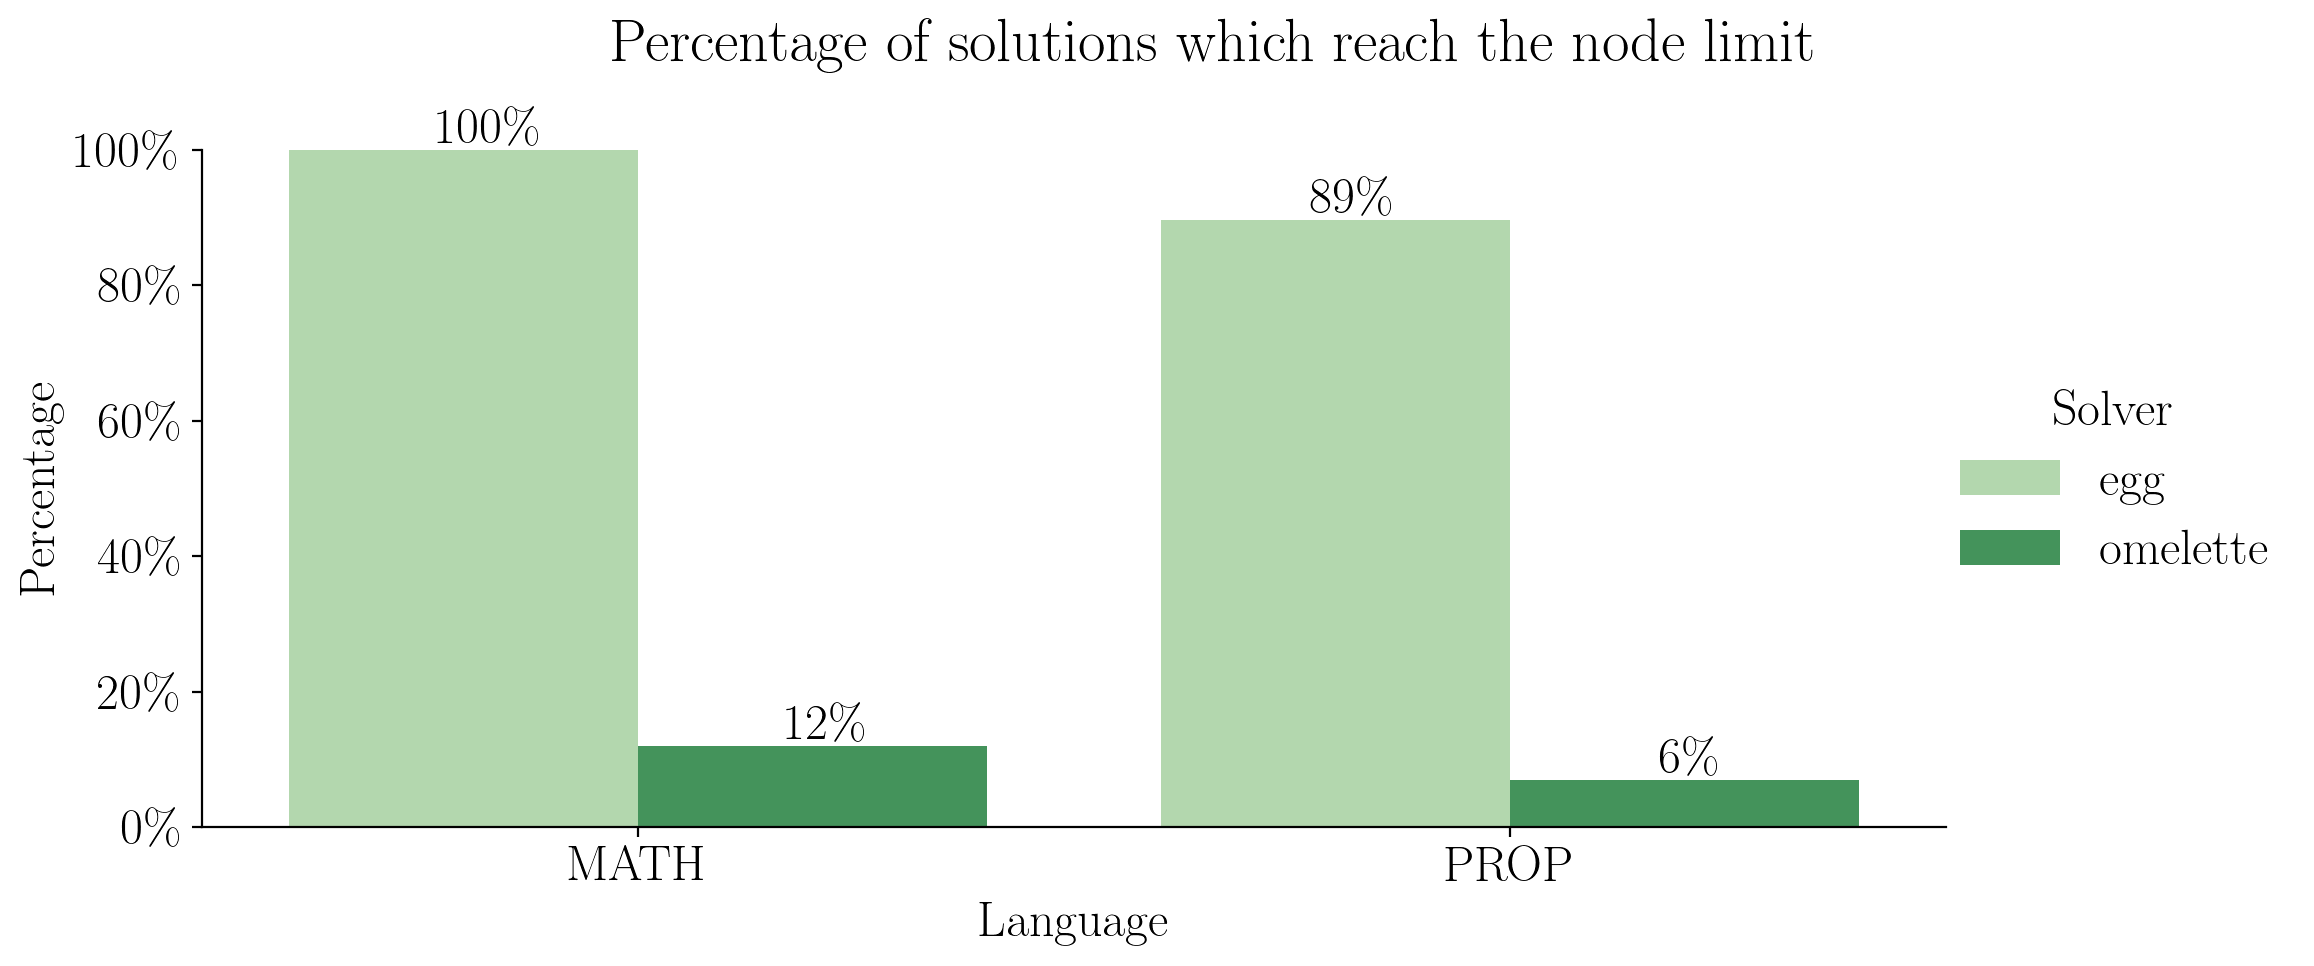

In [429]:
# Proportion in which egg hits node limit
df_math = expr_summary(lang="MathLang")["Stop Reason"].reset_index()
df_math["lang"] = "MATH"
df_prop = expr_summary(lang="PropLang")["Stop Reason"].reset_index()
df_prop["lang"] = "PROP"

df = pd.concat([df_math, df_prop])
df = df.melt(id_vars=["Expr", "lang"])
df = df.groupby(["lang", "solver"])["value"].value_counts(normalize=True).mul(100).rename("Percent").reset_index()
df = df[df["value"] == "NODE_LIMIT"]

df = df.rename(columns={"solver": "Solver"})

plt.rcParams['font.size'] = 18

g = sns.catplot(x="lang", y='Percent', hue="Solver", kind='bar', data=df, aspect=2/1, palette="Greens")
g.ax.set_ylim(0,100)
g.fig.subplots_adjust(top=0.85)

g.fig.suptitle('Percentage of solutions which reach the node limit', x=0.53)

g.ax.yaxis.set_major_formatter(mtick.PercentFormatter())
g.set_axis_labels("Language", "Percentage")
for p in g.ax.patches:
    txt = str(int(p.get_height())) + '\%'
    txt_x = p.get_x() + 0.17
    txt_y = p.get_height() + 1
    g.ax.text(txt_x,txt_y,txt)

g.savefig("sync/nodelimit_percent.pdf")

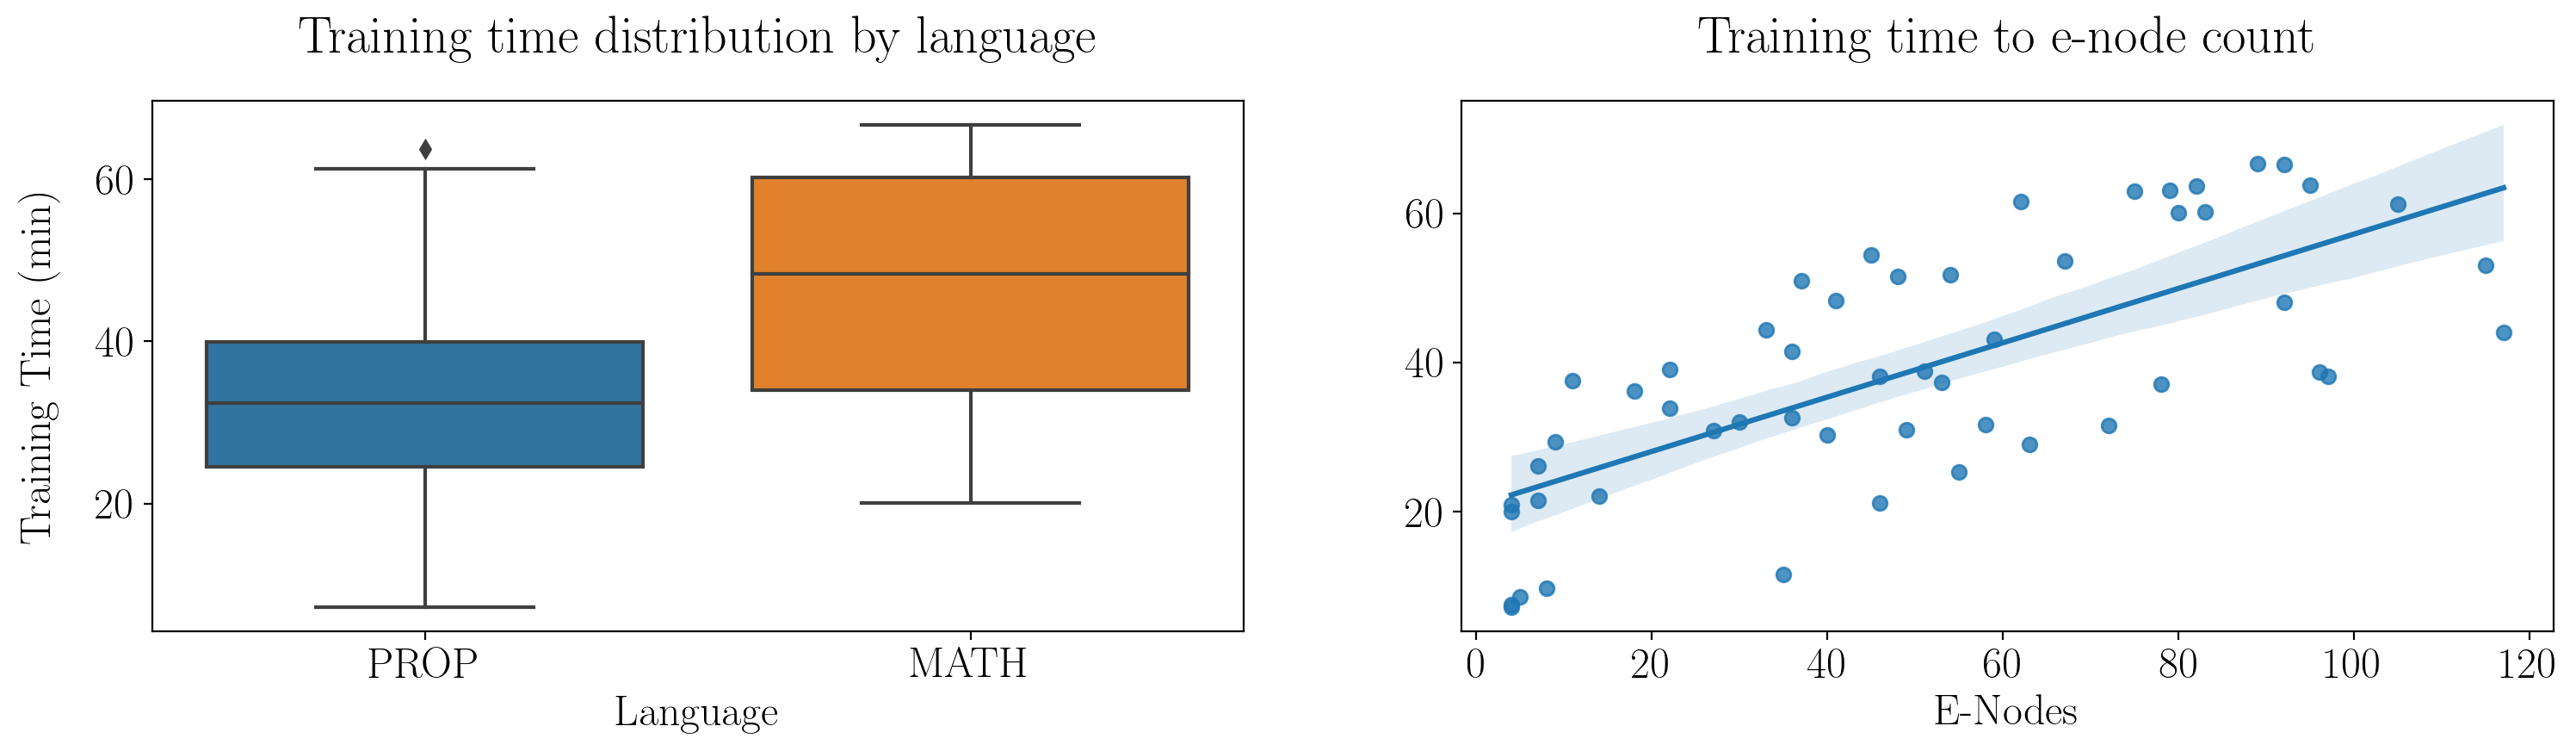

In [344]:
# Training time
# scatter-plot: e-graph size to training time

def build_ttime_summary(lang="PropLang"):
    es = expr_summary(lang)
    ttime = es['Training Time']['omelette']
    ttime = ttime.to_frame(name="Training Time")
    enodes = es['Initial Size']['omelette'] # es['E-Nodes']['omelette']
    enodes = enodes.to_frame(name="E-Nodes")
    eclasses = es['Applications']['omelette']
    eclasses = eclasses.to_frame(name="Applications")
    df = pd.concat([ttime, enodes, eclasses], axis=1).reset_index()
    df = df[df["E-Nodes"] < 150]  # hide one-off outlier (prob caused by multitasking)
    return df

p = build_ttime_summary("PropLang")
p["Language"] = "PROP"
m = build_ttime_summary("MathLang")
m["Language"] = "MATH"

df = pd.concat([p, m])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 4))

g = sns.boxplot(data=df, y="Training Time", x="Language", ax=ax0)
g.yaxis.labelpad = 15
g.set_title("Training time distribution by language", pad=20)
g.yaxis.set_label_text("Training Time (min)")

g2 = sns.regplot(x="E-Nodes", y="Training Time", data=df, ax=ax1)
g2.set_title("Training time to e-node count", pad=20)
g2.yaxis.labelpad = 0
g2.yaxis.set_label_text("")

fig.savefig("sync/ttime.pdf", bbox_inches='tight')

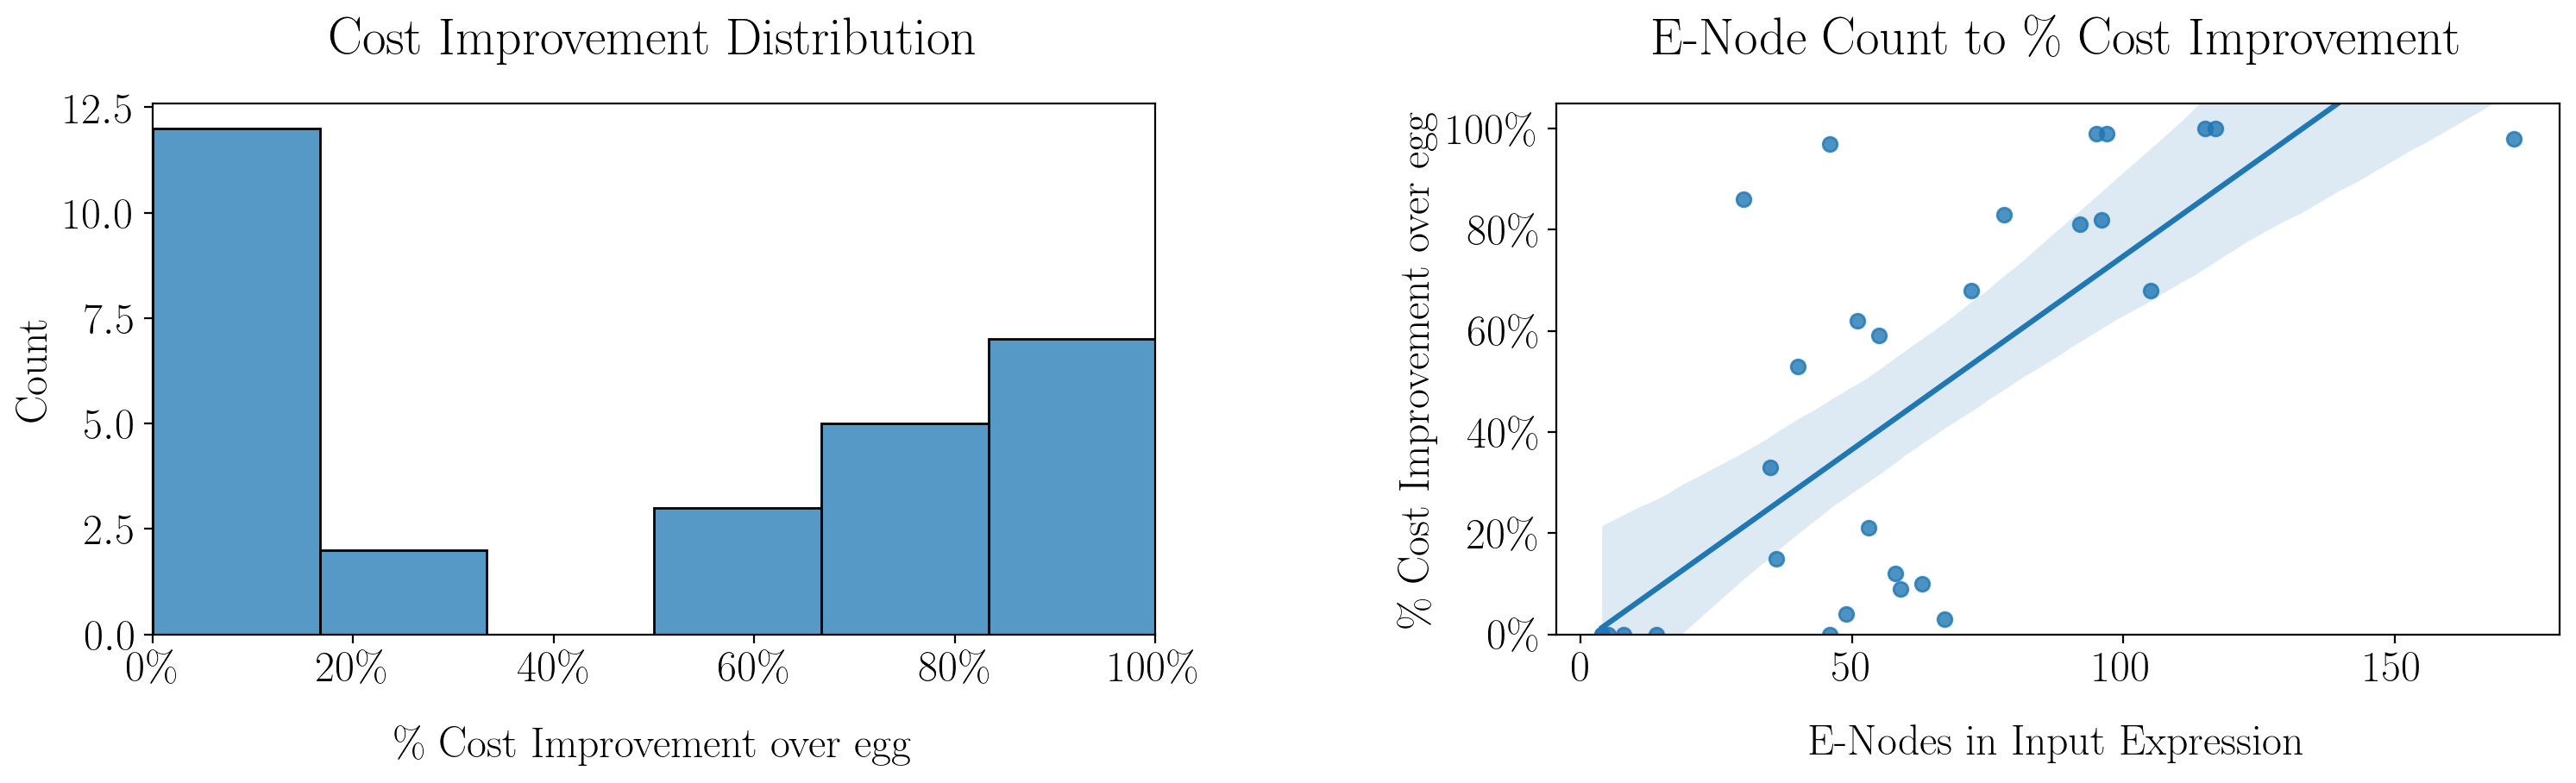

In [430]:
# x axis: node count, y axis: cost reduction percent
df = expr_summary()
size = df["Initial Size"]["omelette"]
cost_p = df["Cost"]['\% Imp']

df = pd.concat([size, cost_p], axis=1)
df = df.rename(columns={'omelette': "E-Nodes"})

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 4))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

g = sns.regplot(ax=ax1, x="E-Nodes", y="\% Imp", data=df, robust=True)
g.set_ylim(0, 105)
g.set(ylabel="\% Cost Improvement over egg", xlabel="E-Nodes in Input Expression")
g.set_title("E-Node Count to \% Cost Improvement", pad=20)
g.yaxis.set_major_formatter(mtick.PercentFormatter())
g.xaxis.labelpad = 15


g2 = sns.histplot(data=df, x="\% Imp", ax=ax0)
g2.xaxis.set_major_formatter(mtick.PercentFormatter())
g2.set_title("Cost Improvement Distribution", pad=20)
g2.set(xlabel="\% Cost Improvement over egg")
g2.set_xlim(0, 100)
g2.xaxis.labelpad = 15

fig.savefig("sync/costs.pdf", bbox_inches='tight')


In [389]:
# Frequency of rebase action

# write some code to re-run agent for each task WITHOUT the use of rebase to see how it affects final perf


,expr_ind,solver,init_expr
0,0,egg,1
1,0,omelette,4
2,1,egg,1
3,1,omelette,1
4,10,egg,1
5,10,omelette,1
6,11,egg,1
7,11,omelette,2
8,12,egg,1
9,12,omelette,1


    index       variable  value
0       0         \% Imp   33.0
1       1         \% Imp   97.0
2       2         \% Imp   21.0
3       3         \% Imp   68.0
4       4         \% Imp    4.0
5       5         \% Imp    0.0
6       6         \% Imp   53.0
7       7         \% Imp   10.0
8       8         \% Imp   99.0
9       9         \% Imp    0.0
10     10         \% Imp    0.0
11     11         \% Imp   98.0
12     12         \% Imp    0.0
13     13         \% Imp   59.0
14     14         \% Imp   81.0
15     15         \% Imp    9.0
16     16         \% Imp   12.0
17     17         \% Imp   86.0
18     18         \% Imp   99.0
19     19         \% Imp  100.0
20     20         \% Imp  100.0
21     21         \% Imp   68.0
22     22         \% Imp   83.0
23     23         \% Imp   82.0
24     24         \% Imp   62.0
25     25         \% Imp    0.0
26     26         \% Imp    3.0
27     27         \% Imp    0.0
28     28         \% Imp   15.0
29      0  \% Imp (Rand) -633.0
30      

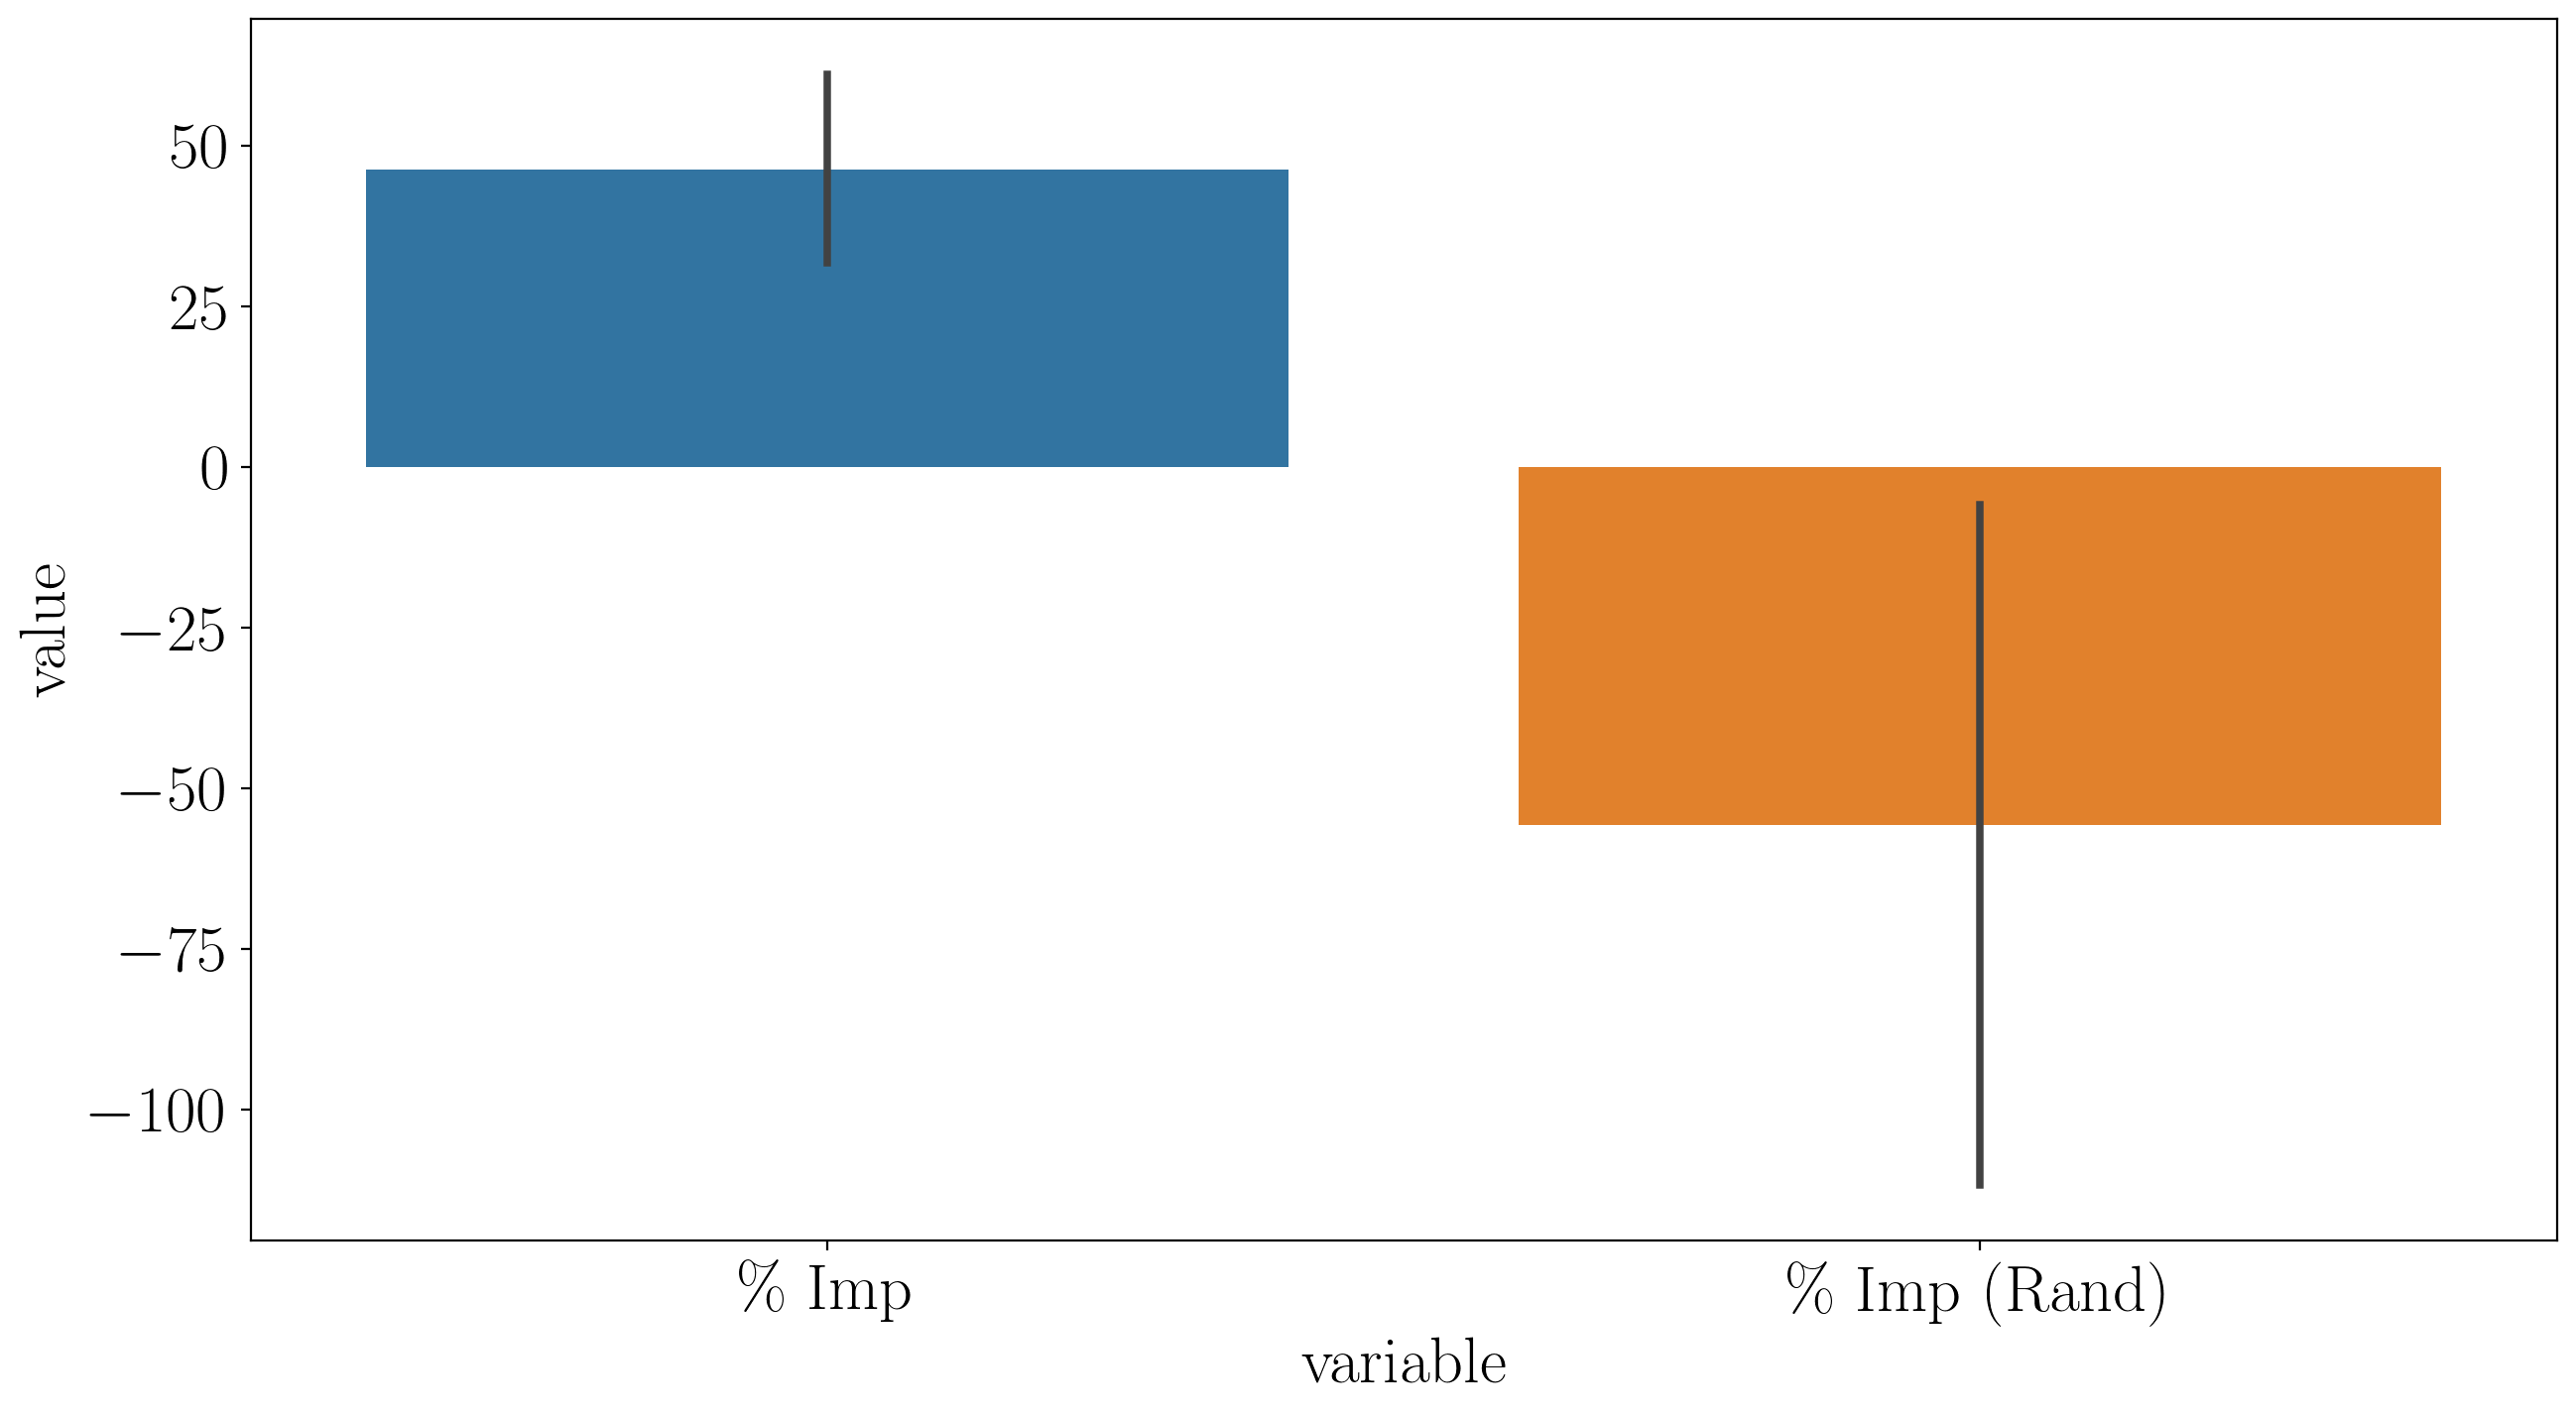

In [464]:
# Barplot for percent improvement across metrics b/w om and random agent

df = expr_summary(lang="PropLang", include_rand=True)

# barplot
# x axis: solver (om or random)
# y axis: % imp

df = df["Cost"].reset_index()
df = pd.concat([df["\% Imp"], df["\% Imp (Rand)"]], axis=1).reset_index()
df = df.melt(id_vars=["index"])
plt.figure(figsize=(15,8))

print(df)

g = sns.barplot(data=df, x="variable", y="value")
# g.set(ylabel="Cost", xlabel="Expression Index")